In [1]:
#Load packages
import sys
import os
import time
import datetime

import numpy as np
import sklearn as sk
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, SimpleRNN, GRU, LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

%load_ext tensorboard
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18})

# Package versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sk.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('### Seaborn version: ' + sns.__version__)
print('------------')

### Python version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
### Numpy version: 1.19.5
### Scikit-learn version: 0.23.2
### Tensorflow version: 2.6.0
### Seaborn version: 0.11.0
------------


In [2]:
# Check GPU Usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
seed = 52
np.random.seed(seed)
tf.random.set_seed(seed)


In [4]:
data = ['open','high', 'low', 'close',
         'open 7d avg', 'high 7d avg', 'low 7d avg', 'close 7d avg',
         'open increase', 'high increase', 'low increase', 'close increase',
         'open 7d increase', 'high 7d increase', 'low 7d increase', 'close 7d increase',
         'row stdev', 'close 7d stdev',
         'close_price_target']

# select proper coin path to begin pipeline training. This file is the source for 3 coin models :BTC / ETH / XRP
# adjust coin var to 0/1/2 for indexing the csv and selecting which model to train
coin_paths = ['Bitstamp_BTCUSD_1h', 'Bitstamp_ETHUSD_1h', 'Bitstamp_XRPUSD_1h']
coin = 2
learning_rates = [0.02, 0.02, 0.001]
data_path = 'Data/' + coin_paths[coin] + '.csv'
prices_df = pd.read_csv(data_path,
                          encoding = "ISO-8859-1")
prices_df = prices_df[prices_df.columns[prices_df.columns.isin(data)]]
prices_df = prices_df[prices_df['close 7d avg'] != 0]
prices_df = prices_df[prices_df.close_price_target != 0]
prices_df

,open,high,low,close,open increase,high increase,low increase,close increase,open 7d avg,high 7d avg,low 7d avg,close 7d avg,open 7d increase,high 7d increase,low 7d increase,close 7d increase,row stdev,close 7d stdev,close_price_target
168,0.38357,0.39019,0.38348,0.38929,-0.015199,-0.013925,-0.015430,-0.001923,0.381104,0.383287,0.378803,0.381103,-0.033171,-0.016906,-0.031665,-0.016994,0.003124,0.018625,0.36448
169,0.38451,0.38600,0.38388,0.38396,0.002451,-0.010738,0.001043,-0.013692,0.381025,0.383247,0.378729,0.381063,-0.025916,-0.027536,-0.026969,-0.030429,0.000851,0.018600,0.36328
170,0.38461,0.38787,0.38271,0.38383,0.000260,0.004845,-0.003048,-0.000339,0.380965,0.383182,0.378665,0.380991,-0.036789,-0.030228,-0.026282,-0.027195,0.001921,0.018565,0.36542
171,0.38254,0.38546,0.38225,0.38461,-0.005382,-0.006213,-0.001202,0.002032,0.380877,0.383110,0.378604,0.380927,-0.040917,-0.036495,-0.041644,-0.036789,0.001358,0.018537,0.36497
172,0.38129,0.38270,0.38120,0.38254,-0.003268,-0.007160,-0.002747,-0.005382,0.380780,0.383023,0.378505,0.380840,-0.042658,-0.042244,-0.041850,-0.040556,0.000691,0.018485,0.36411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39590,0.66730,0.67080,0.66570,0.66980,-0.003732,-0.000596,0.004072,0.010256,0.607606,0.612053,0.602392,0.607083,0.189483,0.152577,0.186631,0.150859,0.002014,0.025256,0.74090
39591,0.67180,0.67220,0.66560,0.66730,0.006744,0.002087,-0.000150,-0.003732,0.608239,0.612582,0.603015,0.607606,0.205455,0.193961,0.198416,0.189483,0.002843,0.025638,0.73300
39592,0.67530,0.67730,0.67150,0.67180,0.005210,0.007587,0.008864,0.006744,0.608920,0.613232,0.603671,0.608239,0.206755,0.205160,0.209474,0.205455,0.002432,0.025791,0.73600
39593,0.67270,0.67660,0.67070,0.67530,-0.003850,-0.001034,-0.001191,0.005210,0.609609,0.613918,0.604364,0.608920,0.217777,0.206491,0.216138,0.206755,0.002286,0.025948,0.74060


In [5]:
# Leave 1 feature out importance on original set of features NOTE: tried but did not seem to work?
# possibly because it required categorical features (increase/decrease) where at the hour level, a small amount could easily 
# swing the class label

#from sklearn.model_selection import KFold
#from lofo import LOFOImportance, Dataset, plot_importance

#sample_df = prices_df.sample(frac=0.01, random_state=seed)
#cv = KFold(n_splits=4, shuffle=False, random_state=seed)
#target="target class"
#dataset = Dataset(df=sample_df, target=target, features=[col for col in prices_df.columns if col != target])
#lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")
#importance_df = lofo_imp.get_importance()
#plot_importance(importance_df, figsize=(12, 20))

In [6]:
# Convert from a df to a numpy array
prices_data = np.asarray(prices_df, dtype='float64')
#assert prices_data.shape[1] == 32

all_x = prices_data[:, range(0, prices_data.shape[1] - 1)]
all_y = prices_data[:, prices_data.shape[1] - 1]
all_x.shape, all_y.shape

((39427, 18), (39427,))

<AxesSubplot:>

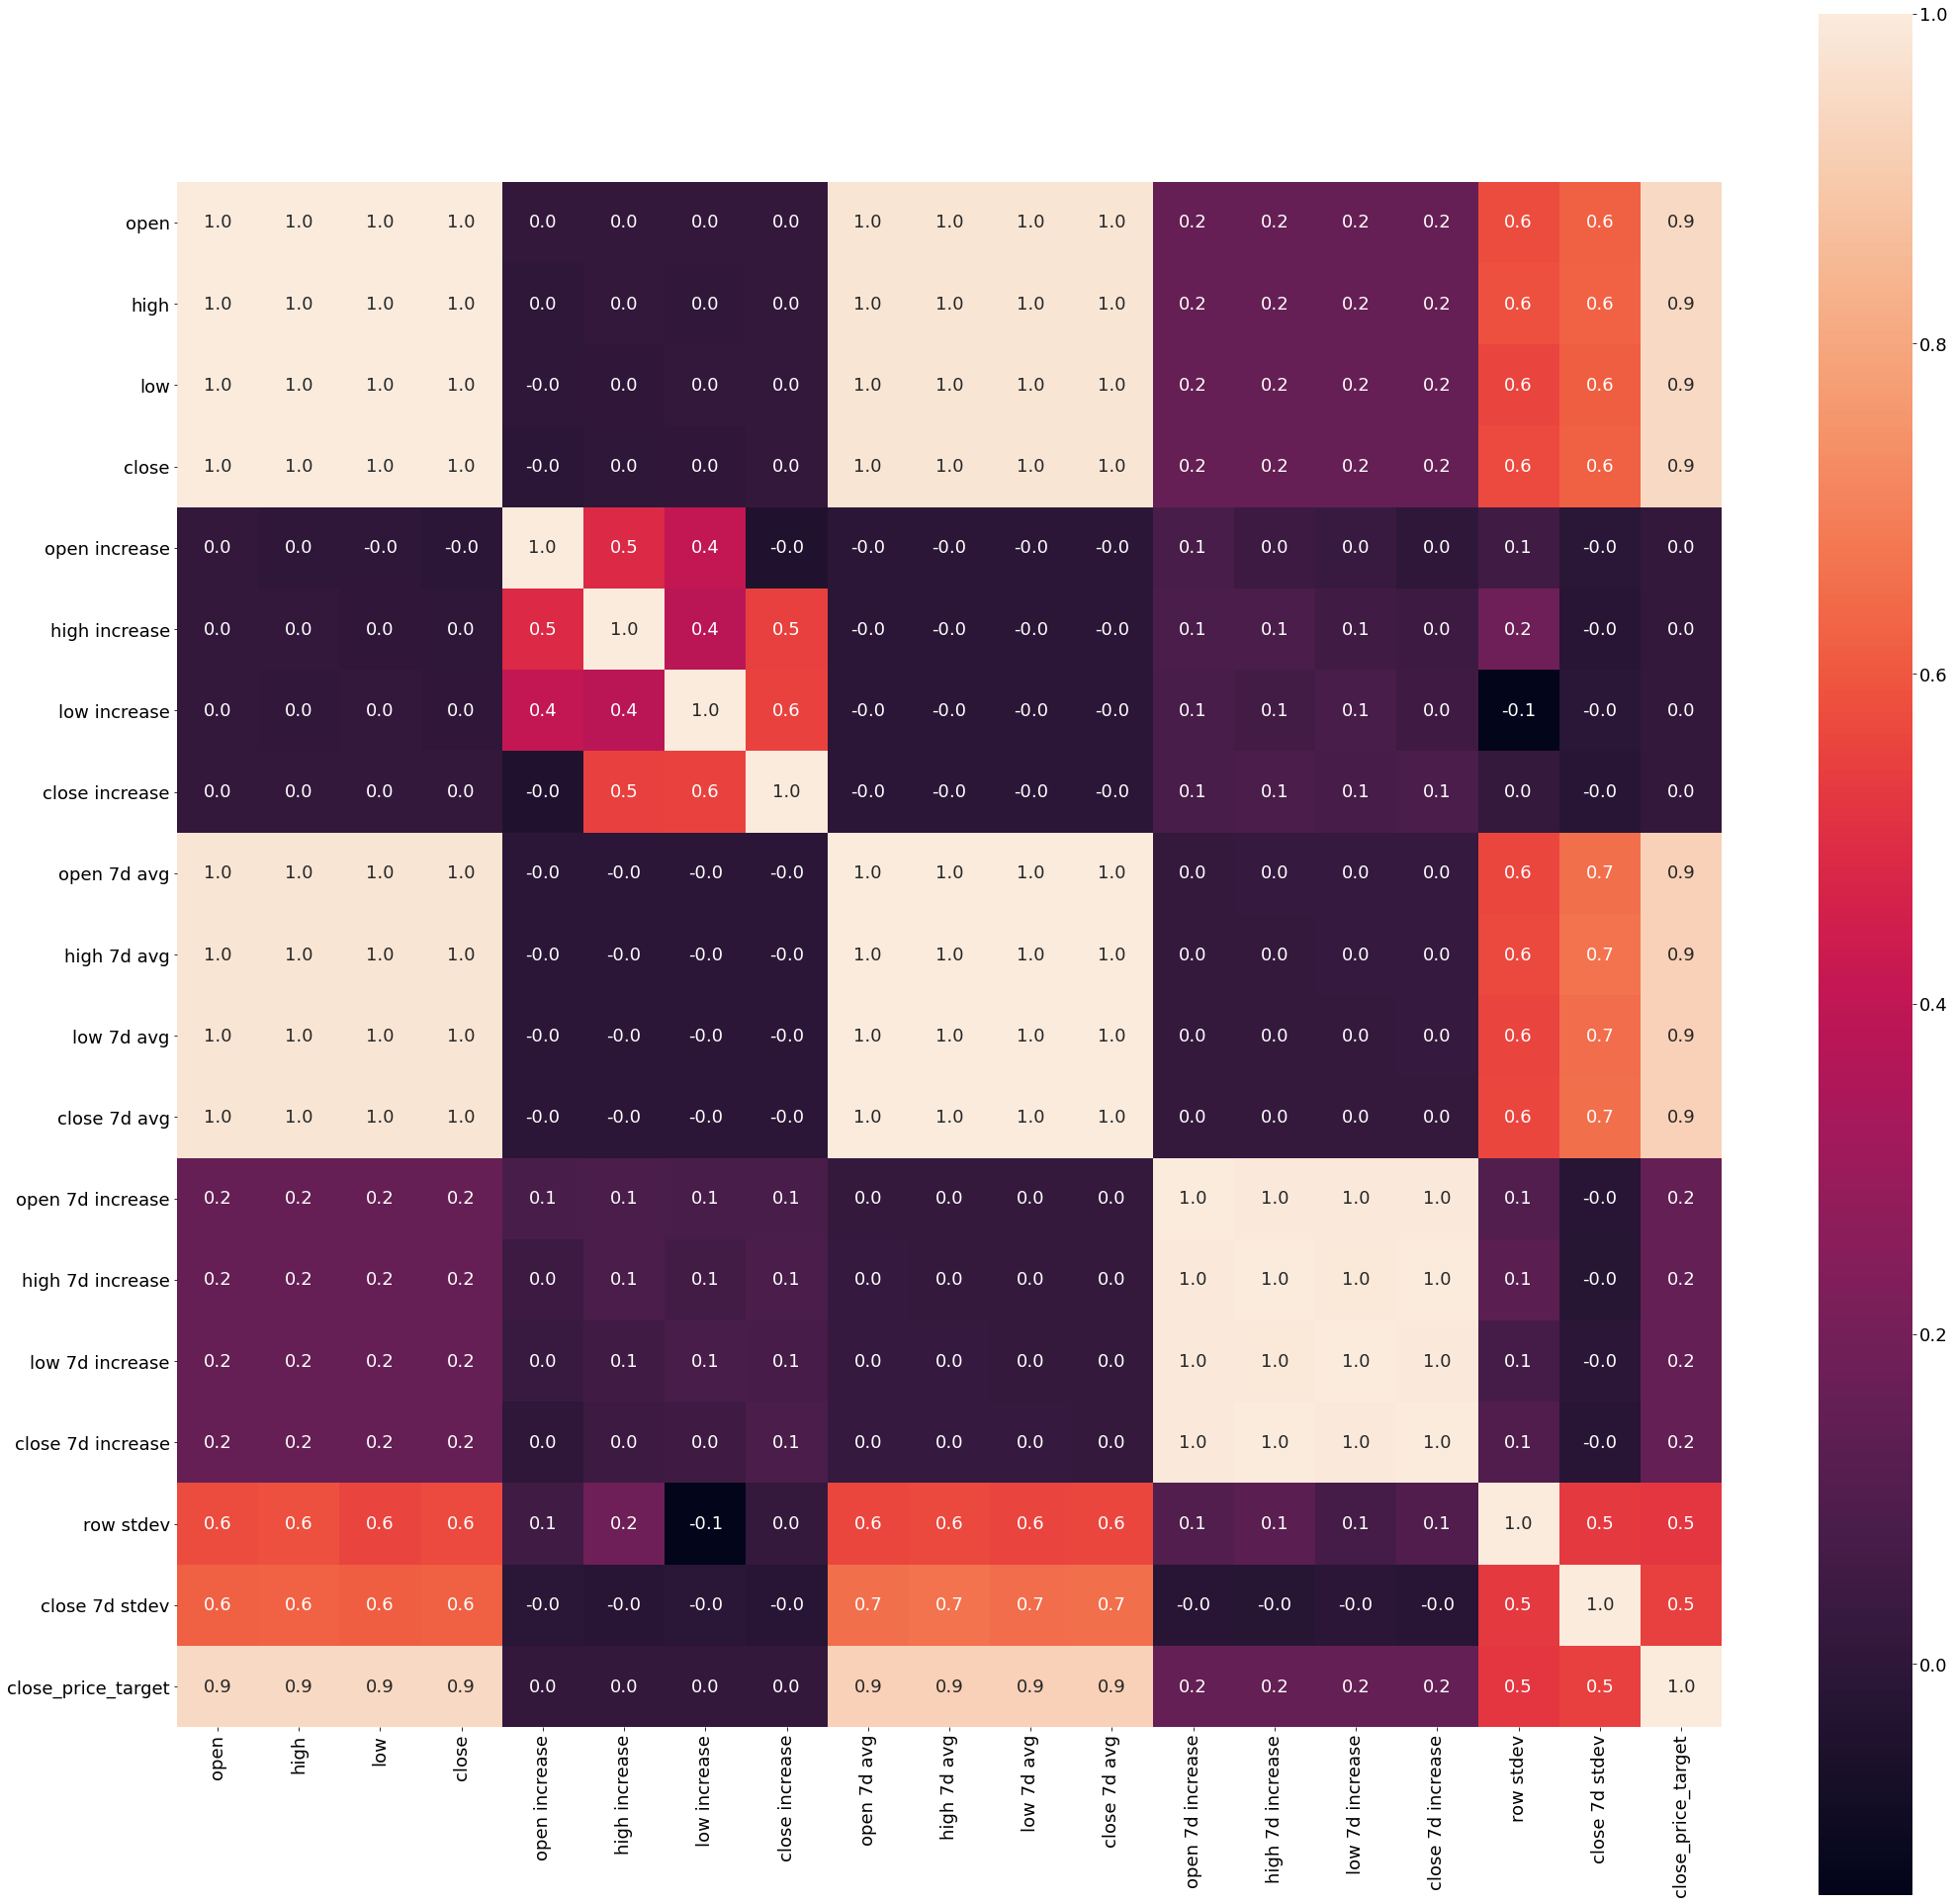

In [7]:
fig, ax = plt.subplots(figsize=(35,35))  
sns.heatmap(prices_df.corr(), annot=True, fmt='0.1f', square=True)

In [8]:
from sklearn.preprocessing import MinMaxScaler 
def min_max_normalize(data):
    tempData = data.copy()
    scaler = MinMaxScaler()
    scaler.fit(tempData)
    return scaler.transform(tempData)

In [9]:
# normalize data
all_x_n = min_max_normalize(all_x)

In [10]:

#get baseline for later

all_x_r = all_x

# tuples
tuples = 168;
rows = len(all_x_n) - (tuples - 1)
features = len(all_x_n[0])
main_counter = 0;

# extract into [t...t+n]
all_x_r_tuples = np.empty([rows, tuples, features], 'float64')
all_y_r_tuples = np.empty([rows, tuples, 1], 'float64')
for x in range(0, all_x_r.shape[0] - (tuples - 1)):
    tempx = np.empty([tuples, features], 'float64')
    tempy = np.empty([tuples, 1], 'float64')
    counter = 0;
    for y in range(x, x+tuples):
        tempx[counter] = all_x_r[y]
        tempy[counter] = all_y[y]
        counter = counter + 1
    all_x_r_tuples[main_counter] = tempx
    all_y_r_tuples[main_counter] = tempy
    main_counter = main_counter + 1
    

train_x_b, test_x_b, train_y_b, test_y_b = train_test_split(all_x_r_tuples, all_y_r_tuples, test_size = .2, random_state = seed)
test_x_b, val_x_b, test_y_b, val_y_b = train_test_split(test_x_b, test_y_b, test_size = .5, random_state = seed)

In [11]:
# PCA NOTE: tried PCA but resulted in worse performance>
#from sklearn.decomposition import PCA, KernelPCA
#pca = PCA(n_components = .99)
#pca.fit(all_x_n)
#all_x_n = pca.transform(all_x_n)

In [12]:
# tuples
tuples = 168;
rows = len(all_x_n) - (tuples - 1)
features = len(all_x_n[0])
main_counter = 0;

# extract into [t...t+n]
all_x_tuples = np.empty([rows, tuples, features], 'float64')
all_y_tuples = np.empty([rows, tuples, 1], 'float64')
for x in range(0, all_x_n.shape[0] - (tuples - 1)):
    tempx = np.empty([tuples, features], 'float64')
    tempy = np.empty([tuples, 1], 'float64')
    counter = 0;
    for y in range(x, x+tuples):
        tempx[counter] = all_x_n[y]
        tempy[counter] = all_y[y]
        counter = counter + 1
    all_x_tuples[main_counter] = tempx
    all_y_tuples[main_counter] = tempy
    main_counter = main_counter + 1

In [13]:
print((all_x_tuples[:,:,:].max()))

1.0000000000000002


In [14]:
# train test split data .2661
train_x, test_x, train_y, test_y = train_test_split(all_x_tuples, all_y_tuples, test_size = .2, random_state = seed)

# verify shapes
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((31408, 168, 18), (7852, 168, 18), (31408, 168, 1), (7852, 168, 1))

In [15]:
# test val split data
test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size = .5, random_state = seed)

# verify shapes
test_x.shape, val_x.shape, test_y.shape, val_y.shape

((3926, 168, 18), (3926, 168, 18), (3926, 168, 1), (3926, 168, 1))

In [16]:
train_y.shape, test_y.shape, val_y.shape

((31408, 168, 1), (3926, 168, 1), (3926, 168, 1))

In [17]:
def rnn_setup(lr, activation_fun, input_shape=(2,31)):
    model = keras.models.Sequential(name='Prices-basic-RNN')
    
    # Add input and middle layers
    model.add(keras.Input(shape=input_shape, name='Input-layer'))
    model.add(GRU(input_shape[0], return_sequences=True, name='GRU-1'))   
    model.add(Flatten())
    model.add(Dense(input_shape[0], activation = 'linear', name='Dense-1'))
    
    # Add output layers
    model.add(Dense(input_shape[0], activation=activation_fun, name='Dense-2'))
    model.summary()
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    
    loss_function = 'mse';
    model.compile(loss=loss_function, optimizer=opt, metrics=['mae'])
    
    return model   
    

In [18]:
#output activation layers = ['btc', 'eth', 'xrp']. XRP uses relu because its value is  near 0 (~0.35USD as of 11/14)
output_activation_layers = ['linear', 'linear', 'relu']
prices_model = rnn_setup(learning_rates[coin], output_activation_layers[coin], input_shape=(tuples,features))

Model: "Prices-basic-RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU-1 (GRU)                  (None, 168, 168)          94752     
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
Dense-1 (Dense)              (None, 168)               4741800   
_________________________________________________________________
Dense-2 (Dense)              (None, 168)               28392     
Total params: 4,864,944
Trainable params: 4,864,944
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = [450, 50, 125]
batch_size = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
prices_model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=num_epochs[coin], batch_size=batch_size, callbacks=callback)

Epoch 1/125
315/315 [==============================] - 12s 18ms/step - loss: 0.1408 - mae: 0.2262 - val_loss: 0.1177 - val_mae: 0.2041: 0
Epoch 2/125
315/315 [==============================] - 5s 16ms/step - loss: 0.1138 - mae: 0.1952 - val_loss: 0.1127 - val_mae: 0.1913
Epoch 3/125
315/315 [==============================] - 5s 16ms/step - loss: 0.1106 - mae: 0.1893 - val_loss: 0.1116 - val_mae: 0.1953
Epoch 4/125
315/315 [==============================] - 5s 16ms/step - loss: 0.1094 - mae: 0.1869 - val_loss: 0.1107 - val_mae: 0.1881
Epoch 5/125
315/315 [==============================] - 5s 16ms/step - loss: 0.0962 - mae: 0.1727 - val_loss: 0.0339 - val_mae: 0.0965
Epoch 6/125
315/315 [==============================] - 5s 17ms/step - loss: 0.0201 - mae: 0.0644 - val_loss: 0.0189 - val_mae: 0.0642
Epoch 7/125
315/315 [==============================] - 5s 16ms/step - loss: 0.0179 - mae: 0.0588 - val_loss: 0.0181 - val_mae: 0.0576
Epoch 8/125
315/315 [==============================] - 5s 

315/315 [==============================] - 6s 18ms/step - loss: 8.6297e-04 - mae: 0.0207 - val_loss: 0.0010 - val_mae: 0.0219
Epoch 62/125
315/315 [==============================] - 6s 19ms/step - loss: 8.4907e-04 - mae: 0.0205 - val_loss: 9.5509e-04 - val_mae: 0.0215
Epoch 63/125
315/315 [==============================] - 6s 20ms/step - loss: 7.9442e-04 - mae: 0.0199 - val_loss: 0.0010 - val_mae: 0.0226
Epoch 64/125
315/315 [==============================] - 6s 19ms/step - loss: 7.9432e-04 - mae: 0.0200 - val_loss: 9.2001e-04 - val_mae: 0.0214
Epoch 65/125
315/315 [==============================] - 6s 19ms/step - loss: 7.8042e-04 - mae: 0.0198 - val_loss: 7.6565e-04 - val_mae: 0.0194
Epoch 66/125
315/315 [==============================] - 6s 20ms/step - loss: 7.4539e-04 - mae: 0.0194 - val_loss: 0.0012 - val_mae: 0.0254
Epoch 67/125
315/315 [==============================] - 7s 23ms/step - loss: 7.3122e-04 - mae: 0.0193 - val_loss: 7.2844e-04 - val_mae: 0.0193
Epoch 68/125
315/315 [==

Epoch 118/125
315/315 [==============================] - 9s 28ms/step - loss: 2.3490e-04 - mae: 0.0112 - val_loss: 2.9033e-04 - val_mae: 0.0125
Epoch 119/125
315/315 [==============================] - 9s 28ms/step - loss: 2.4238e-04 - mae: 0.0114 - val_loss: 3.0032e-04 - val_mae: 0.0126
Epoch 120/125
315/315 [==============================] - 9s 28ms/step - loss: 2.5542e-04 - mae: 0.0116 - val_loss: 4.2029e-04 - val_mae: 0.0142
Epoch 121/125
315/315 [==============================] - 10s 33ms/step - loss: 2.7566e-04 - mae: 0.0120 - val_loss: 2.9610e-04 - val_mae: 0.0125
Epoch 122/125
315/315 [==============================] - 12s 37ms/step - loss: 2.2820e-04 - mae: 0.0110 - val_loss: 2.9169e-04 - val_mae: 0.0123
Epoch 123/125
315/315 [==============================] - 10s 31ms/step - loss: 2.3305e-04 - mae: 0.0112 - val_loss: 3.2097e-04 - val_mae: 0.0130
Epoch 124/125
315/315 [==============================] - 9s 28ms/step - loss: 2.2551e-04 - mae: 0.0109 - val_loss: 2.6716e-04 - val_m

In [20]:
pred = prices_model.predict(val_x)

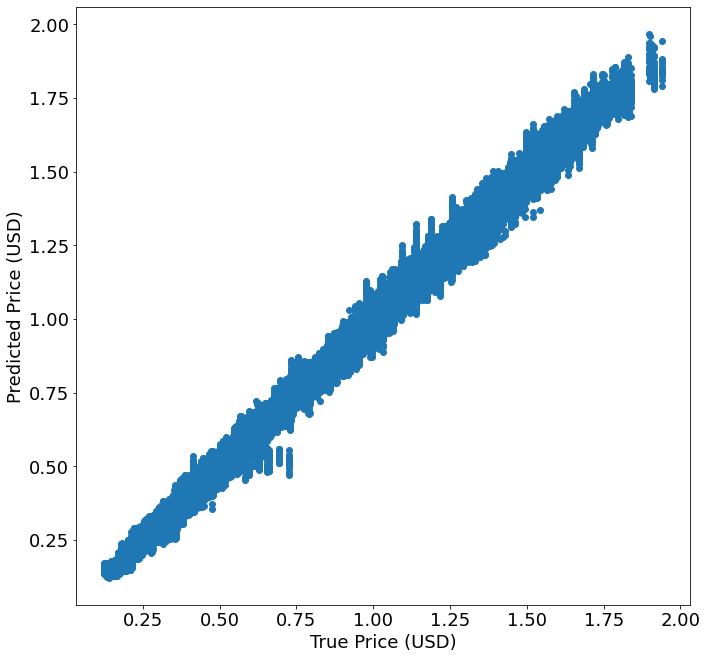

In [21]:
fig = plt.figure(figsize=(11,11))
plt.scatter(val_y, pred)
plt.xlabel('True Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.show()

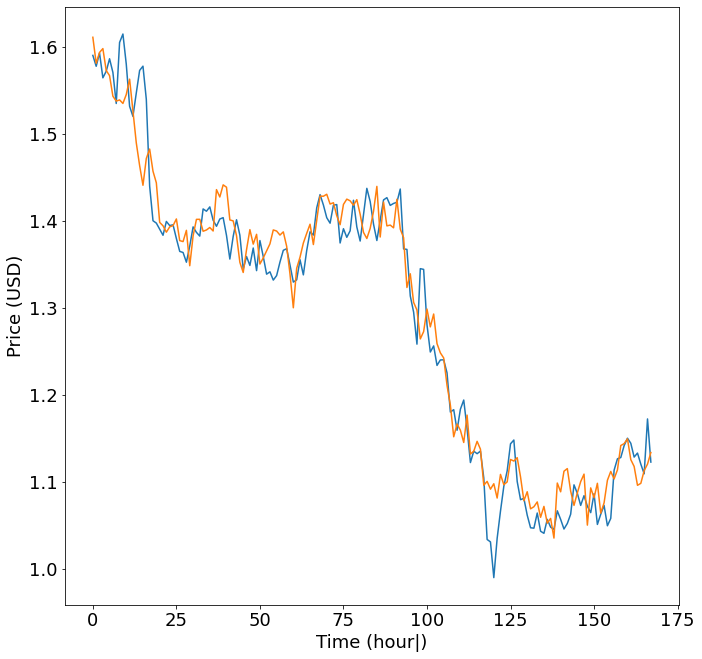

In [22]:
# check 8, 10
fig = plt.figure(figsize=(11,11))
plt.plot(np.arange(0, 168), val_y[10])
plt.plot(np.arange(0, 168), pred[10])
plt.xlabel('Time (hour|)')
plt.ylabel('Price (USD)')
plt.show()

In [30]:
# select name for model based on what coin the model was trained on
coins = ['bitcoin', 'ethereum', 'xrp']
path = "saved_models/" + coins[coin] + "/"
prices_model.save(path)

INFO:tensorflow:Assets written to: saved_models/xrp2/assets


INFO:tensorflow:Assets written to: saved_models/xrp2/assets


In [23]:
#baseline - take the avg price for the previous 7 days and use that as the baseline price per hour for the next 
#168hr/7day predictions
baseline_preds = np.empty([test_x.shape[0], test_x.shape[1]])
for i in range(baseline_preds.shape[0]):
    for j in range(baseline_preds.shape[1]):
        baseline_preds[i,j] = test_x_b[i].mean()
baseline_preds.shape

(3926, 168)

In [24]:
def calc_mae(val_set, pred_set):
    mae = 0
    for i in range(0, len(val_set)):
        for j in range(0, len(val_set[0])):
            mae += abs(val_set[i,j] - pred_set[i,j])
    mae = mae / (len(val_set) * len(val_set[0]))
    print(mae)

In [25]:
calc_mae(test_y, baseline_preds)

[0.26522552]


In [26]:
prices_model.evaluate(test_x, test_y)

123/123 [==============================] - 1s 7ms/step - loss: 3.2506e-04 - mae: 0.0132


[0.00032505893614143133, 0.013206355273723602]

# Extract values to normalize features on the web side

In [24]:
print(prices_df['open'].min(),"-----", prices_df['open'].max())

0.1248 ----- 1.93609


In [25]:
print(prices_df['high'].min(),"-----", prices_df['high'].max())

0.1335 ----- 1.96695


In [26]:
print(prices_df['low'].min(),"-----", prices_df['low'].max())

0.114 ----- 1.9137400000000002


In [27]:
print(prices_df['close'].min(),"-----", prices_df['close'].max())

0.1248 ----- 1.9409299999999998


In [28]:
print(prices_df['open 7d avg'].min(),"-----", prices_df['open 7d avg'].max())

0.148820238 ----- 1.6041351190000002


In [29]:
print(prices_df['high 7d avg'].min(),"-----", prices_df['high 7d avg'].max())

0.15179881 ----- 1.6359154169999999


In [30]:
print(prices_df['low 7d avg'].min(),"-----", prices_df['low 7d avg'].max())

0.14625654800000001 ----- 1.570975298


In [31]:
print(prices_df['close 7d avg'].min(),"-----", prices_df['close 7d avg'].max())

0.148820238 ----- 1.60379744


In [32]:
print(prices_df['open increase'].min(),"-----", prices_df['open increase'].max())

-0.216517568 ----- 0.25130559399999997


In [33]:
print(prices_df['high increase'].min(),"-----", prices_df['high increase'].max())

-0.264248705 ----- 0.342539317


In [34]:
print(prices_df['low increase'].min(),"-----", prices_df['low increase'].max())

-0.191296505 ----- 0.328754324


In [35]:
print(prices_df['close increase'].min(),"-----", prices_df['close increase'].max())

-0.216357584 ----- 0.252640524


In [36]:
print(prices_df['open 7d increase'].min(),"-----", prices_df['open 7d increase'].max())

-0.622031308 ----- 1.686720716


In [37]:
print(prices_df['high 7d increase'].min(),"-----", prices_df['high 7d increase'].max())

-0.640633176 ----- 1.5705813830000002


In [38]:
print(prices_df['low 7d increase'].min(),"-----", prices_df['low 7d increase'].max())

-0.590402931 ----- 1.7156470590000001


In [39]:
print(prices_df['close 7d increase'].min(),"-----", prices_df['close 7d increase'].max())

-0.622334131 ----- 1.6820593000000001


In [40]:
print(prices_df['row stdev'].min(),"-----", prices_df['row stdev'].max())

0.0 ----- 0.14297317199999998


In [41]:
print(prices_df['close 7d stdev'].min(),"-----", prices_df['close 7d stdev'].max())

0.0009896389999999998 ----- 0.296589242


In [27]:
print((tuples,features))

(168, 18)
